In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from nltk.probability import FreqDist

import gensim
from gensim import corpora


In [2]:
df = pd.read_csv("britishthing.csv")
df.head()

,reviews,stars,dateflown,country
0,We chose Rotterdam and London City airport be...,5,Mar/2024,Netherlands
1,The entire booking and ticketing experience ha...,6,Apr/2024,United States
2,British Airways cancelled my flight less tha...,1,Jan/2024,United States
3,I wanted to write this review so I could give ...,1,Mar/2024,United States
4,Check in fast and friendly. Security a breeze...,10,Mar/2024,United Kingdom


In [3]:
df.shape

(3007, 4)

In [4]:
df.dtypes

reviews      object
stars         int64
dateflown    object
country      object
dtype: object

In [5]:
df['reviews'].isnull().sum()



0

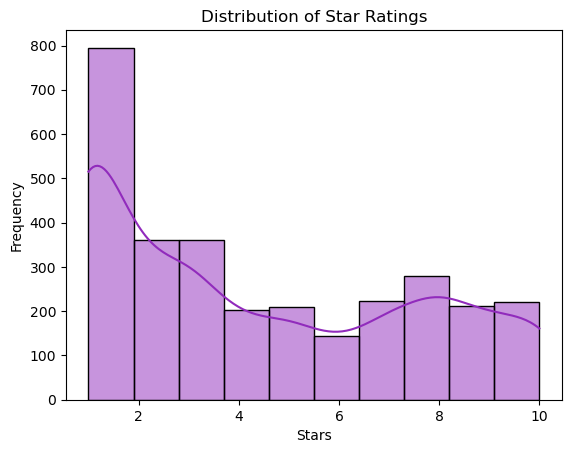

In [6]:
# Histogram of star ratings
sns.histplot(data=df, x='stars', bins=10, kde=True,color='#912BBC')
plt.title('Distribution of Star Ratings')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.show()


In [7]:
mean_stars = df['stars'].mean()
print("The mean of star ratings is:", mean_stars)

The mean of star ratings is: 4.3990688393747925


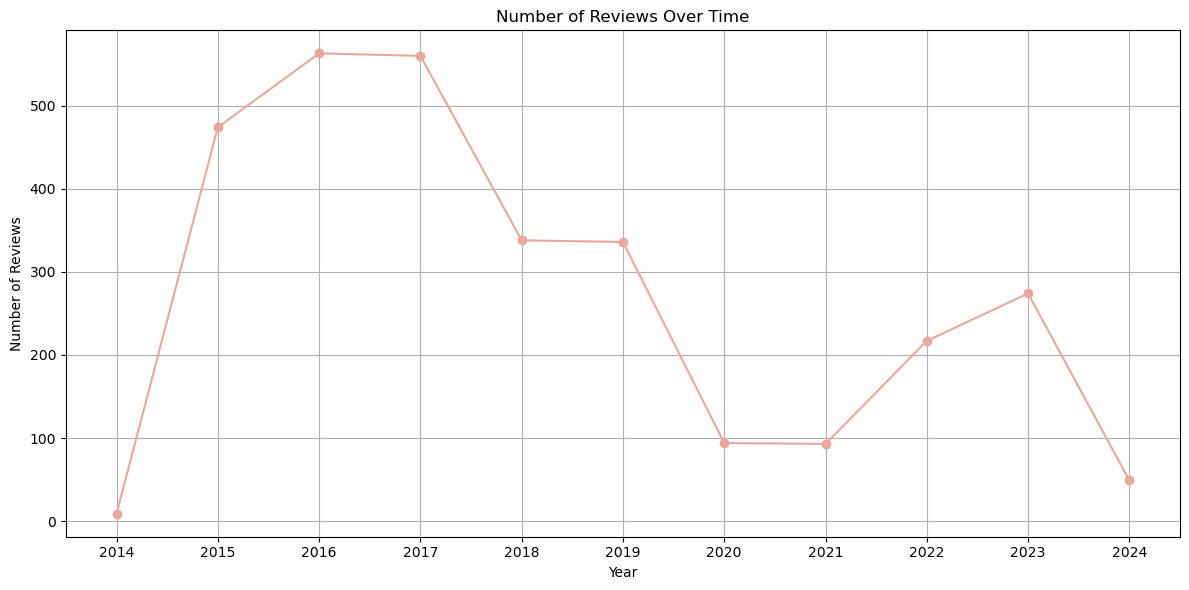

In [8]:
#which time had the most reviews , distribution in time of reviewing

df['dateflown'] = pd.to_datetime(df['dateflown'], format='%b/%Y') 

# Extract year from 'dateflown' and create a new column
df['year'] = df['dateflown'].dt.year

# Group by 'year' and count the reviews
review_counts = df.groupby('year').size().reset_index(name='counts')

# Sorting by 'year' (implicitly sorted by 'year' due to grouping)
review_counts = review_counts.sort_values('year')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(review_counts['year'], review_counts['counts'], marker='o', linestyle='-',color='#E9A89B')
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(review_counts['year'])  # Ensure all years are labeled
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [9]:
unique_country_count = df['country'].nunique()
print("Number of unique countries:", unique_country_count)


Number of unique countries: 69


           Country  Total Ratings
66  United Kingdom           8341
67   United States           1517
1        Australia            460
9           Canada            380
22         Germany            260


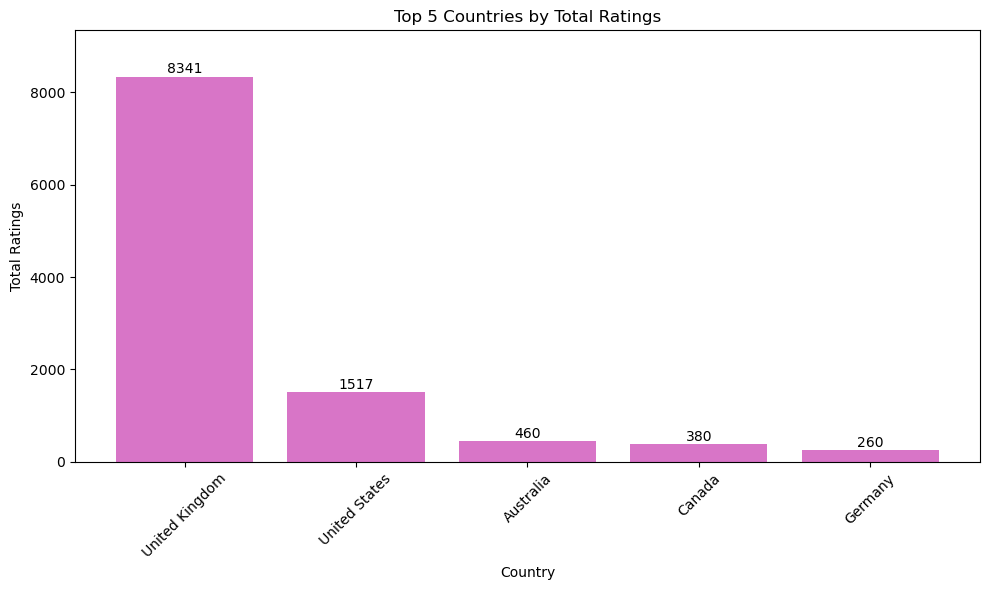

In [10]:
# Calculate sum of ratings by country
total_ratings = df.groupby('country')['stars'].sum().reset_index()
total_ratings.columns = ['Country', 'Total Ratings']

# Sort by 'Total Ratings' in descending order and select top 5
top_5_countries = total_ratings.sort_values('Total Ratings', ascending=False).head(5)
print(top_5_countries)

# Plotting total ratings for the top 5 countries
plt.figure(figsize=(10, 6))
bars = plt.bar(top_5_countries['Country'], top_5_countries['Total Ratings'],color='#D875C7')
plt.xlabel('Country')
plt.ylabel('Total Ratings')
plt.title('Top 5 Countries by Total Ratings')
plt.ylim(0, top_5_countries['Total Ratings'].max() + 1000)  # Adjust ylim based on max rating plus a margin

# Annotate each bar with the value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval), ha='center', va='bottom')

plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


                  Country  Total Ratings
44                 Panama              3
26                Hungary              3
17     Dominican Republic              2
13             Costa Rica              2
11                  Chile              2
10         Cayman Islands              2
51  Saint Kitts and Nevis              1
29              Indonesia              1
3                 Bahrain              1
34                 Jordan              1


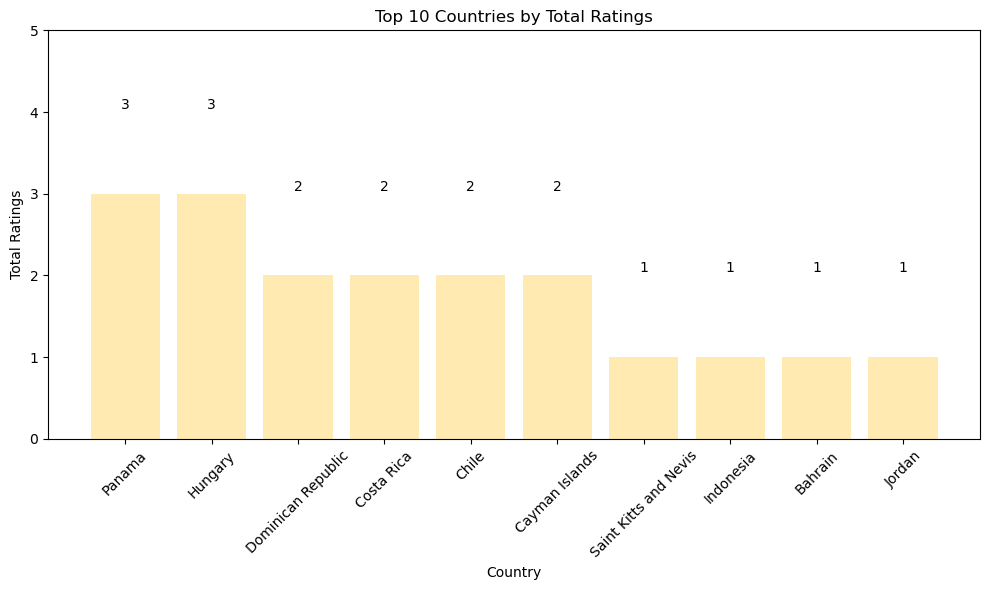

In [11]:
# Calculate sum of ratings by country
total_ratings = df.groupby('country')['stars'].sum().reset_index()
total_ratings.columns = ['Country', 'Total Ratings']

# Sort by 'Total Ratings' in descending order and select top 5
top_5_countries = total_ratings.sort_values('Total Ratings', ascending=False).tail(10)
print(top_5_countries)

# Plotting total ratings for the top 5 countries
plt.figure(figsize=(10, 6))
bars = plt.bar(top_5_countries['Country'], top_5_countries['Total Ratings'],color='#FFEBB2')
plt.xlabel('Country')
plt.ylabel('Total Ratings')
plt.title('Top 10 Countries by Total Ratings')
plt.ylim(0, top_5_countries['Total Ratings'].max() + 2)  # Adjust ylim based on max rating plus a margin

# Annotate each bar with the value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval), ha='center', va='bottom')

plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

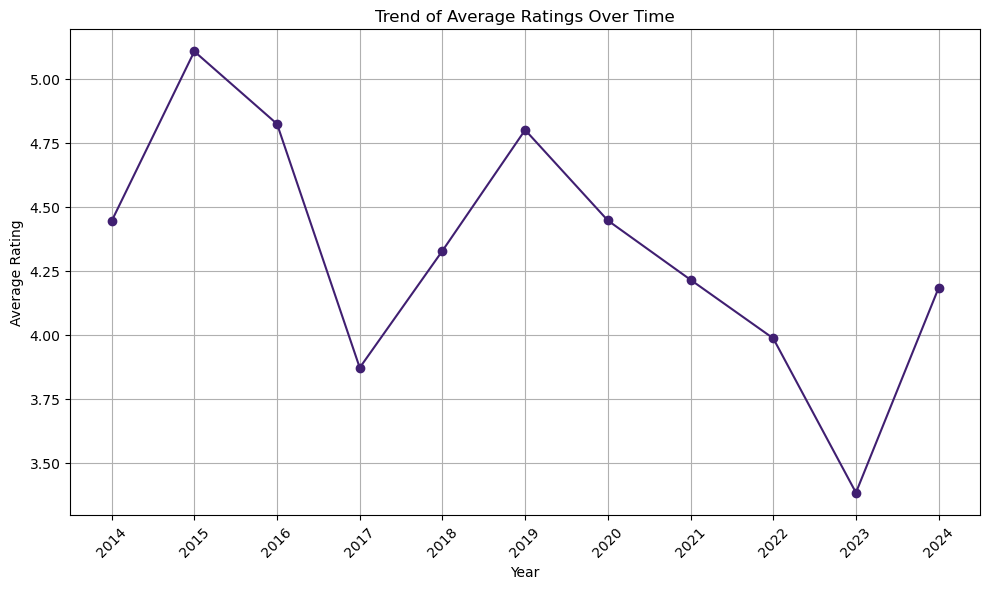

In [12]:
#Ratings vs. Time: Analyze if there’s a trend in ratings over time.
#For instance, are ratings improving or declining as years go by?
# Group by the 'year' and calculate the mean of ratings
ratings_over_time = df.groupby('year')['stars'].mean().reset_index()
ratings_over_time.columns = ['Year', 'Average Rating']

# Plotting the trend of ratings over time
plt.figure(figsize=(10, 6))
plt.plot(ratings_over_time['Year'].astype(str), ratings_over_time['Average Rating'], marker='o', linestyle='-',color= '#401F71')
plt.title('Trend of Average Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
#plt.ylim(0, 10)  # Adjust this to encompass the full range of your rating scale
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.tight_layout()  # Adjust layout to fit and prevent label cut-off
plt.show()


In [13]:
df

,reviews,stars,dateflown,country,year
0,We chose Rotterdam and London City airport be...,5,2024-03-01,Netherlands,2024
1,The entire booking and ticketing experience ha...,6,2024-04-01,United States,2024
2,British Airways cancelled my flight less tha...,1,2024-01-01,United States,2024
3,I wanted to write this review so I could give ...,1,2024-03-01,United States,2024
4,Check in fast and friendly. Security a breeze...,10,2024-03-01,United Kingdom,2024
...,...,...,...,...,...
3002,We were boarded quickly but suffered a weather...,2,2015-05-01,United Kingdom,2015
3003,Terrible. Flight time is well over 2 hours. Se...,6,2015-05-01,United Kingdom,2015
3004,"28th May 2015, LHR-DEN, B747, Seat 29A. Paid ...",1,2015-06-01,United Kingdom,2015
3005,"9/6/15, ORD-LHR, 777-300, Club World, Seat 13b...",8,2015-06-01,United Kingdom,2015


In [14]:
import re

def fix_contractions(doc):
    doc = re.sub(r'https?://\S+|www\.\S+', " ", doc)
    doc = re.sub(r"won't", "will not", doc)
    doc = re.sub(r"can't", "can not", doc)
    doc = re.sub(r"n't", " not", doc)
    doc = re.sub(r"'ll", " will", doc)
    doc = re.sub(r"'re", " are", doc)
    doc = re.sub(r"'ve", " have", doc)
    doc = re.sub(r"'m", " am", doc)
    doc = re.sub(r"'d", " would", doc)
    doc = re.sub(r"'s", "", doc)
    doc = re.sub(r"\n", " ", doc)
    doc = re.sub(r"[^a-zA-Z0-9 ]", " ", doc)
    return doc

df['reviews'] = df["reviews"].apply(fix_contractions)

In [15]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    #Remove digits
    filtered_tokens = [token for token in filtered_tokens if not token.isdigit()]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [16]:
# apply the function df
df['reviews'] = df["reviews"].astype(str).apply(preprocess_text)


In [17]:
def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    # Calculate overall sentiment based on compound score
    if sentiment_scores['compound'] >= 0.75:
         sentiment = 'Pos+'
    elif sentiment_scores['compound'] >= 0.5:
         sentiment = 'Pos'
    elif sentiment_scores['compound'] <= -0.75:
         sentiment = 'Neg+'
    elif sentiment_scores['compound'] <= -0.5:
         sentiment = 'Neg'
    else:
         sentiment = 'Neutral'

    scores = sentiment_scores['compound']

    return scores, sentiment

In [18]:
df[['sentiment_scores','sentiment']] = df['reviews'].apply(analyze_sentiment).tolist()


In [19]:
df.sentiment_scores = df.sentiment_scores.astype(float)

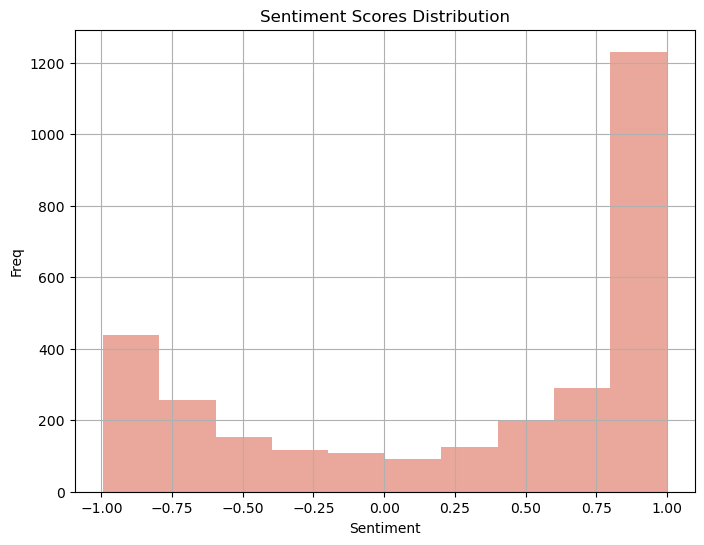

In [20]:
# Plot sentiment score distribution
plt.figure(figsize=(8, 6))
df['sentiment_scores'].hist(color='#E9A89B')
plt.xlabel('Sentiment')
plt.ylabel('Freq')
plt.title('Sentiment Scores Distribution')
plt.show()

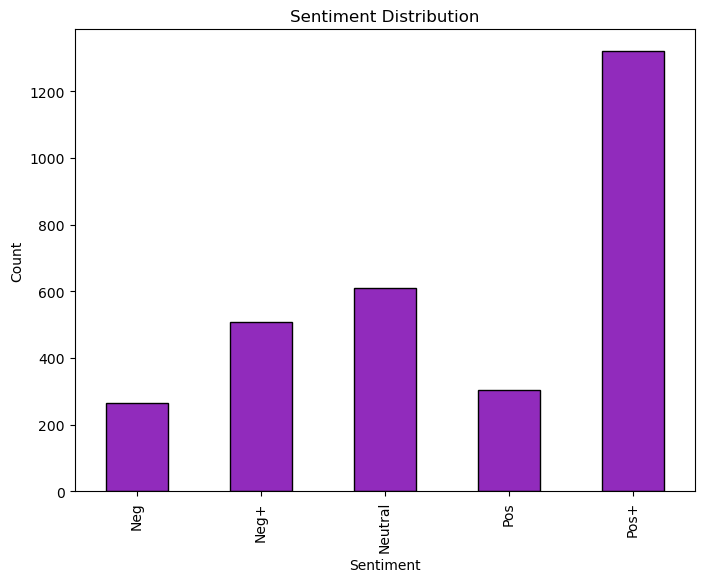

In [21]:
plt.figure(figsize=(8, 6))
df['sentiment'].value_counts().sort_index().plot(kind='bar', color='#912BBC', edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


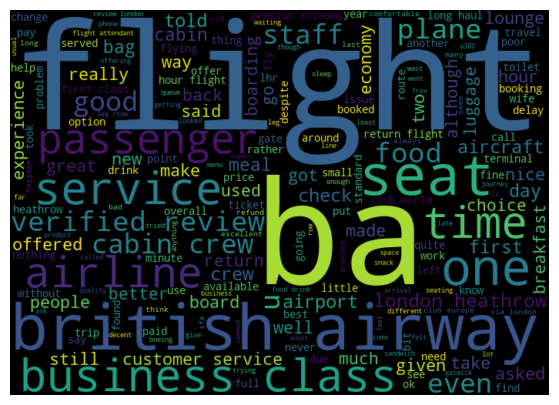

In [22]:
text = " ".join(review for review in df.reviews)

# Create and generate a word cloud image
wordcloud = WordCloud(height=500,width=700,background_color='black').generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

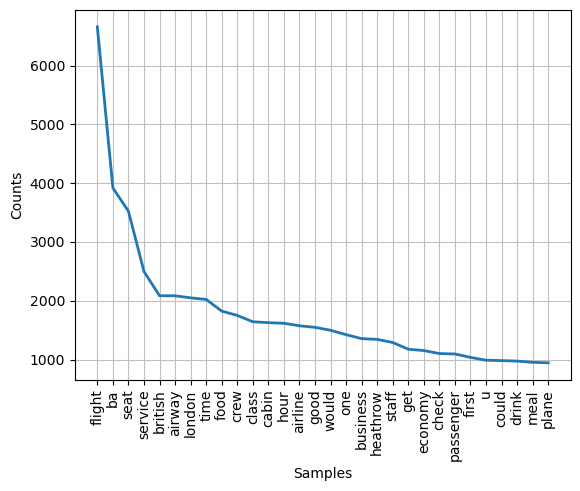

In [23]:


# Tokenize and clean each review, then flatten into a single list of words
all_words = [word.lower() for review in df['reviews'] for word in word_tokenize(review) if word.isalpha()]

# Filter out stopwords
filtered_words = [word for word in all_words if word not in stopwords.words('english')]

# Create the frequency distribution
freq_dist = FreqDist(filtered_words)

# Plot the most common words
freq_dist.plot(30, cumulative=False)
plt.show()



In [24]:
df

,reviews,stars,dateflown,country,year,sentiment_scores,sentiment
0,chose rotterdam london city airport convenienc...,5,2024-03-01,Netherlands,2024,0.3818,Neutral
1,entire booking ticketing experience stressful ...,6,2024-04-01,United States,2024,-0.9595,Neg+
2,british airway cancelled flight le hour automa...,1,2024-01-01,United States,2024,-0.7650,Neg+
3,wanted write review could give huge thank one ...,1,2024-03-01,United States,2024,0.9637,Pos+
4,check fast friendly security breeze lounge bus...,10,2024-03-01,United Kingdom,2024,0.9686,Pos+
...,...,...,...,...,...,...,...
3002,boarded quickly suffered weather delay hour lo...,2,2015-05-01,United Kingdom,2015,0.7334,Pos
3003,terrible flight time well hour seating like ry...,6,2015-05-01,United Kingdom,2015,-0.2732,Neutral
3004,28th may lhr den b747 seat 29a paid extra legr...,1,2015-06-01,United Kingdom,2015,0.9678,Pos+
3005,ord lhr club world seat 13b booked world trave...,8,2015-06-01,United Kingdom,2015,0.9776,Pos+


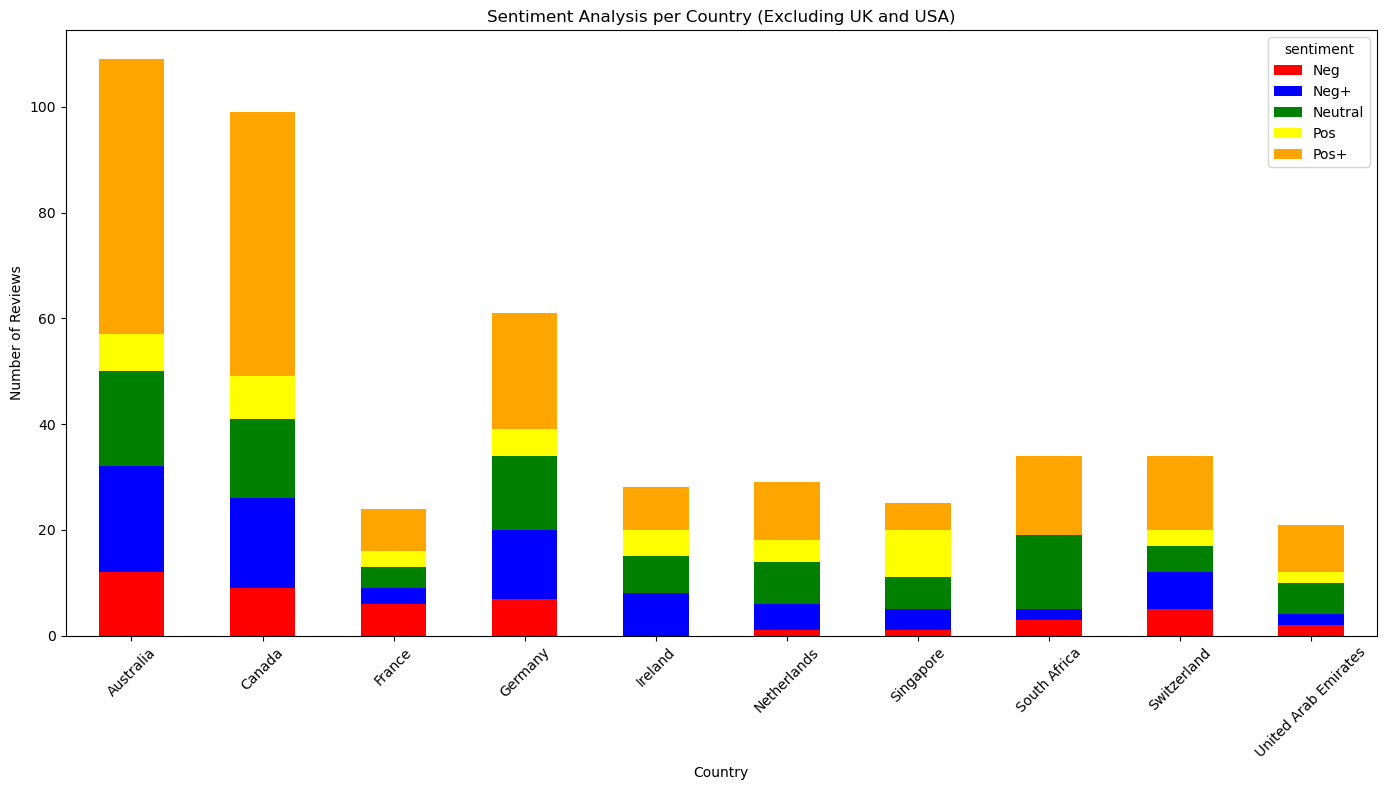

In [25]:
# Rename DataFrame from df to dfk
dfk = df.copy()

# Exclude reviews from the United Kingdom and the United States
dfk = dfk[(dfk['country'] != 'United Kingdom') & (dfk['country'] != 'United States')]

# Calculate the count of reviews per country and sort them to pick the top 20
top_countries = dfk['country'].value_counts().head(10).index

# Filter the DataFrame to include only the top 20 countries
top_countries_dfk = dfk[dfk['country'].isin(top_countries)]

# Group by country and sentiment to count occurrences
sentiment_counts = top_countries_dfk.groupby(['country', 'sentiment']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'blue', 'green', 'yellow', 'orange'], ax=ax)
ax.set_title('Sentiment Analysis per Country (Excluding UK and USA)')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


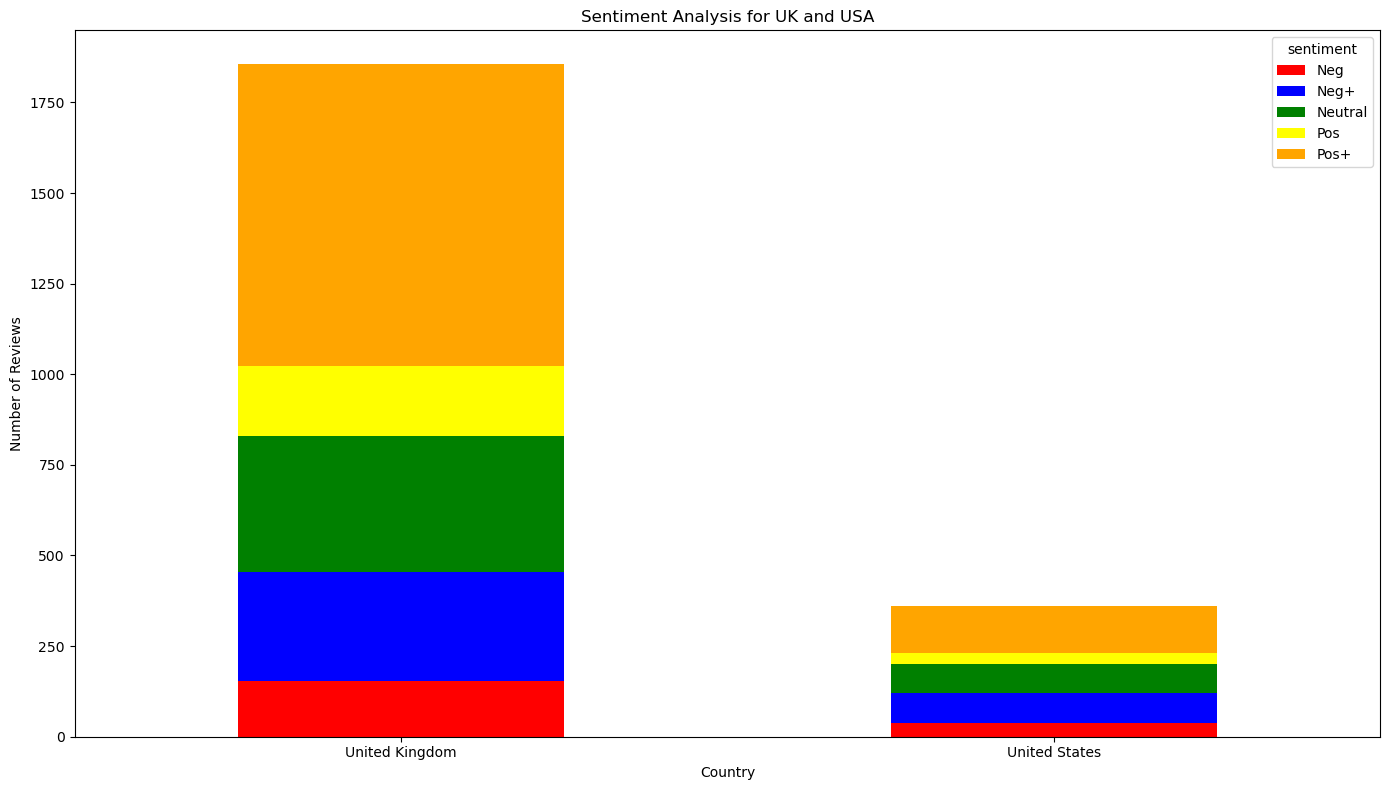

In [26]:

dfg = df.copy()
# Include only reviews from the United Kingdom and the United States
dfg = dfg[(dfg['country'] == 'United States') | (dfg['country'] == 'United Kingdom')]

# Ensure the sentiment data is ready for plotting
if 'sentiment' in dfg.columns and dfg['sentiment'].dtype == object:
    dfg['sentiment'] = pd.Categorical(dfg['sentiment'])

# Group by country and sentiment to count occurrences
sentiment_counts = dfg.groupby(['country', 'sentiment']).size().unstack(fill_value=0)

# Check if the DataFrame is non-empty and has data to plot
if not sentiment_counts.empty:
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))
    sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'blue', 'green', 'yellow', 'orange'], ax=ax)
    ax.set_title('Sentiment Analysis for UK and USA')
    ax.set_xlabel('Country')
    ax.set_ylabel('Number of Reviews')
    plt.xticks(rotation=0)  # Rotate ticks to improve readability
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("No data to plot.")


In [28]:
# Filter the DataFrame to only include 'Neg+' sentiment reviews
neg_reviews = df[df['sentiment'] == 'Neg']['reviews']


In [32]:
# Assuming neg_reviews contains raw string text that needs to be tokenized
neg_reviews = neg_reviews.apply(lambda x: x.split())


In [34]:
# Create a dictionary from the processed tokens
dictionary = corpora.Dictionary(neg_reviews)

# Create a corpus from the dictionary
corpus = [dictionary.doc2bow(text) for text in neg_reviews]


In [33]:
neg_reviews

10      [trip, verified, overall, would, say, disappoi...
31      [supposed, flight, cancelled, hour, takeoff, n...
52      [overall, journey, bad, however, end, baggage,...
70      [going, fly, frankfurt, glasgow, london, fligh...
81      [flown, ba, year, read, review, preparation, n...
                              ...                        
2891    [booked, first, class, paying, passenger, airl...
2901    [british, airway, charged, large, carry, leavi...
2906    [outgoing, flight, fine, return, flight, cance...
2921    [frequent, long, haul, traveller, although, of...
2952    [encouraged, passenger, check, online, save, s...
Name: reviews, Length: 265, dtype: object

In [40]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10,  
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the topics found by the LDA model
for idx, topic in lda_model.print_topics(num_words=5):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.015*"amsterdam" + 0.013*"club" + 0.012*"staff" + 0.012*"morning" + 0.011*"could"
Topic: 1 
Words: 0.004*"blocked" + 0.002*"restriction" + 0.002*"stammer" + 0.002*"applying" + 0.002*"m25"
Topic: 2 
Words: 0.016*"trolley" + 0.014*"started" + 0.011*"afternoon" + 0.009*"fuss" + 0.008*"lax"
Topic: 3 
Words: 0.038*"flight" + 0.021*"ba" + 0.011*"time" + 0.011*"hour" + 0.010*"heathrow"
Topic: 4 
Words: 0.044*"seat" + 0.034*"class" + 0.026*"business" + 0.014*"economy" + 0.011*"airline"
Topic: 5 
Words: 0.015*"separate" + 0.012*"zero" + 0.010*"changing" + 0.010*"within" + 0.008*"affected"
Topic: 6 
Words: 0.015*"voucher" + 0.013*"ticket" + 0.012*"ba" + 0.012*"refund" + 0.012*"instead"
Topic: 7 
Words: 0.036*"flight" + 0.025*"british" + 0.024*"airway" + 0.016*"london" + 0.014*"hour"
Topic: 8 
Words: 0.028*"meal" + 0.025*"served" + 0.017*"service" + 0.015*"seat" + 0.012*"drink"
Topic: 9 
Words: 0.017*"stressful" + 0.012*"operator" + 0.004*"straightforward" + 0.002*"virus" + 0.00